# Viklund - Classifying news articles 

In [1]:
%matplotlib inline

from pathlib import Path
import os

import pandas as pd

import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

## Loading text data

In [2]:
# DATA_DIR = Path('..', 'data')
current_dir = os.path.dirname(os.path.abspath('Viklund-News Classifier'))
bbc_folder_path = os.path.join(current_dir, 'bbc')
bbc_folder_path = Path(bbc_folder_path)

In [3]:
# news_path = DATA_DIR / 'bbc'
bbc_collections = sorted(list(bbc_folder_path.glob('**/*.txt'))) 
news_dict = {'category':[], 'title': [], 'content': []}
news_dataset = pd.DataFrame()
for i, file in enumerate (bbc_collections):
    category = file.parts[-2]
    text_data = file.read_text(encoding='latin1').split('\n')
    title=text_data[0].strip()
    content=' '.join([l.strip() for l in text_data[1:]])
    news_dict['category'].append(category)
    news_dict['title'].append(title)
    news_dict['content'].append(content)
    new_row = {'category':category, 'title':title, 'content':content }

news_dataset['category'] = news_dict['category']
news_dataset['title'] = news_dict['title']
news_dataset['content'] = news_dict['content']

#     documents.append([category, title, content])

In [4]:
news_dataset

,category,title,content
0,business,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...
...,...,...,...
2220,tech,BT program to beat dialler scams,BT is introducing two initiatives to help bea...
2221,tech,Spam e-mails tempt net shoppers,Computer users across the world continue to i...
2222,tech,Be careful how you code,A new European directive could put software w...
2223,tech,US cyber security chief resigns,The man making sure US computer networks are ...


In [5]:
news_dataset[news_dataset.category == 'business']

,category,title,content
0,business,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...
...,...,...,...
505,business,Trial begins of Spain's top banker,"The trial of Emilio Botin, the chairman of Sp..."
506,business,UK economy ends year with spurt,The UK economy grew by an estimated 3.1% in 2...
507,business,HealthSouth ex-boss goes on trial,The former head of US medical services firm H...
508,business,Euro firms miss out on optimism,More than 90% of large companies around the w...


In [6]:
news_dataset.content[896]

' Maternity pay for new mothers is to rise by Â£1,400 as part of new proposals announced by the Trade and Industry Secretary Patricia Hewitt.  It would mean paid leave would be increased to nine months by 2007, Ms Hewitt told GMTV\'s Sunday programme. Other plans include letting maternity pay be given to fathers and extending rights to parents of older children. The Tories dismissed the maternity pay plan as "desperate", while the Liberal Democrats said it was misdirected.  Ms Hewitt said: "We have already doubled the length of maternity pay, it was 13 weeks when we were elected, we have already taken it up to 26 weeks. "We are going to extend the pay to nine months by 2007 and the aim is to get it right up to the full 12 months by the end of the next Parliament." She said new mothers were already entitled to 12 months leave, but that many women could not take it as only six of those months were paid. "We have made a firm commitment. We will definitely extend the maternity pay, from th

In [7]:

news_dataset.describe(include='all')

,category,title,content
count,2225,2225,2225
unique,5,2096,2092
top,sport,Microsoft seeking spyware trojan,Microsoft has warned PC users to update their...
freq,511,2,2


<Axes: xlabel='category', ylabel='count'>

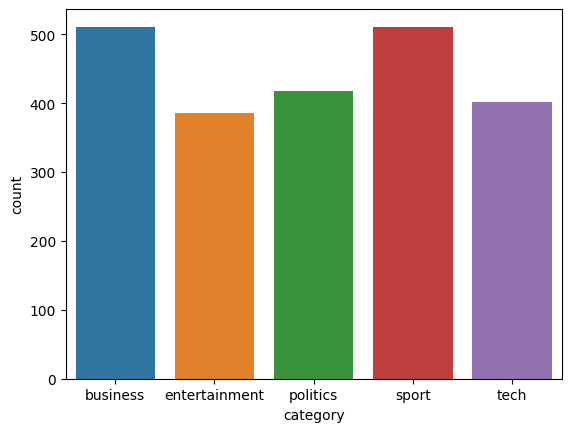

In [8]:
sns.countplot(x='category', data=news_dataset)

In [9]:
import re
from keras.preprocessing.text import one_hot, Tokenizer
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import stopwords
lemmatizer = WordNetLemmatizer()
tokenizer = nltk.RegexpTokenizer(r"\w+")
stop_words = set(stopwords.words('english'))

In [10]:
def preprocess_twtr_text(tweet_):

    # Remove links, mentions     
    # reduce all text to lower case
    tweet_ = tweet_.lower()

    #Remove mentions
    tweet_ = re.sub('@\S+', ' ', tweet_)
    
    #Remove any links
    tweet_ = re.sub('https?:\S+|http?:\S', ' ', tweet_)
    
    # Remove puntuations and numbers
    tweet_ = re.sub('[^a-zA-Z]', ' ', tweet_)

    # Single character removal 
    tweet_ = re.sub(r"\s+[a-zA-z]\s+", ' ', tweet_)

    # Remove multiple spaces
    tweet_ = re.sub(r'\s+', ' ', tweet_)
    
    # Lematize
    tokens_result = tokenizer.tokenize(tweet_)
    lemmatized_tokens = [lemmatizer.lemmatize(t) for t in tokens_result]

    pattern_ = re.compile(r'\b(' + r'|'.join(stop_words) + r')\b\s*')
    tweet_ = pattern_.sub('', tweet_)

    return tweet_



In [11]:
def Xtrain_pre_processing(x_feature):
    feature = []
    tweets_ = list(x_feature)
    for twt in tweets_:
        feature.append(preprocess_twtr_text(twt))
    return feature

In [12]:
X = Xtrain_pre_processing(news_dataset['content'])
y = pd.factorize(news_dataset['category'])
y_legend = y[1]
y = y[0]


In [13]:
X[500]

' conflict argentine state water firm aguas argentinas controlled france suez casting doubt firm future firm serves province buenos aires wants tariff rise fund water supply improvements government rejected rise wants aguas argentinas make annual investment pesos improvements planning minister julio de vido offered state help free mr de vido said argentine state would make contribution form subsidy said contribution could made return seat company board added government discussions aguas argentinas role might take event state contribution agreed however aguas argentinas told argentine newspaper clarin would accept change legal structure practice rules state participation board planning minister rule possibility cancelling aguas argentinas water concession yet added like futurology last week argentine economic minister roberto lavagna told french media paris government considering allowing increase tariffs possibility state contribution aguas argentinas infrastructure investments speakin

In [14]:
X 

[' quarterly profits us media giant timewarner jumped bn three months december year earlier firm one biggest investors google benefited sales high speed internet connections higher advert sales timewarner said fourth quarter sales rose bn bn profits buoyed one gains offset profit dip warner bros less users aol time warner said friday owns search engine google internet business aol mixed fortunes lost subscribers fourth quarter profits lower preceding three quarters however company said aol underlying profit exceptional items rose back stronger internet advertising revenues hopes increase subscribers offering online service free timewarner internet customers try sign aol existing customers high speed broadband timewarner also restate results following probe us securities exchange commission sec close concluding time warner fourth quarter profits slightly better analysts expectations film division saw profits slump helped box office flops alexander catwoman sharp contrast year earlier th

In [15]:
y

array([0, 0, 0, ..., 4, 4, 4], dtype=int64)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42, stratify=y)

# Vectorization

Quantifying the text data into numerical format is vitale for Viklunds understanding of the category to which a news article belongs. To transform text to its numerical format we will need to vectorize it.

**Count Vectorizer**

Count Vectorizer allows the text input to easily be transformed into a numerical format that machine learning algorithms can understand using vectorizer. It is helpful for activities like text analysis, document classification, and clustering. It is less effective in capturing the semantic meaning of text because it doesn't take into account the significance of words or their context.

In [17]:
count_vector = CountVectorizer()

# fit_transform
X_train_count_vec = count_vector.fit_transform(X_train)
# transform
X_test_count_vec = count_vector.transform(X_test)

In [18]:
print(X_train_count_vec.shape, X_test_count_vec.shape)

(1780, 25182) (445, 25182)


**TFIDF Vectorizer**

When compared to straightforward word count representations (like CountVectorizer), the TFIDF method takes into account the relevance of terms in the documents based on their TF-IDF values, which frequently results in enhanced performance. Practically speaking, this approach incorporates both the local and global relevance of words in texts, making it suitable for our particular text analysis task...document categorization. The TF-IDF scores of words that are common in a given text but uncommon elsewhere in the corpus tend to be higher, and these words are frequently regarded as key terms or features for that document.

In [19]:
tfidf_vector = TfidfVectorizer()

# fit_transform
X_train_tfidf_vec = tfidf_vector.fit_transform(X_train)
# transform
X_test_tfidf_vec = tfidf_vector.transform(X_test)

In [20]:
print(X_train_tfidf_vec.shape, X_test_tfidf_vec.shape)

(1780, 25182) (445, 25182)


# Train Model

**CountVectorizer**

In [21]:
# Multinomial Naive Bayes model

model = MultinomialNB()
model.fit(X_train_count_vec, y_train)

MultinomialNB()

In [22]:
prediction_results_count = model.predict(X_test_count_vec)
print("CountVectorizer Accuracy : " + str(round((accuracy_score(y_test, prediction_results_count)*100), 2)))


CountVectorizer Accuracy : 98.43


In [23]:
print(y_legend)
pd.DataFrame(confusion_matrix(y_test, prediction_results_count))

Index(['business', 'entertainment', 'politics', 'sport', 'tech'], dtype='object')


,0,1,2,3,4
0,98,0,2,0,2
1,0,76,0,0,1
2,0,0,83,0,1
3,0,0,1,101,0
4,0,0,0,0,80


**TFIDF Vectorizer**

In [24]:
# Multinomial Naive Bayes model

model_tfidf = MultinomialNB()
model_tfidf.fit(X_train_tfidf_vec, y_train)

MultinomialNB()

In [25]:
prediction_results_tfidf = model_tfidf.predict(X_test_tfidf_vec)
print("TF-IDF Vectorizer Accuracy : " + str(round((accuracy_score(y_test, prediction_results_tfidf)*100), 2)))

TF-IDF Vectorizer Accuracy : 98.65


In [26]:
print(y_legend)
pd.DataFrame(confusion_matrix(y_test, prediction_results_tfidf))

Index(['business', 'entertainment', 'politics', 'sport', 'tech'], dtype='object')


,0,1,2,3,4
0,100,0,1,0,1
1,1,75,1,0,0
2,0,0,83,0,1
3,0,0,0,102,0
4,1,0,0,0,79


We see the TF-IDF vectorization approach has a very slight increase in performance

In [27]:
prediction_results_tfidf_test = model_tfidf.predict(X_test_tfidf_vec[:10])
print("TF-IDF Vectorizer Accuracy : " + str(round((accuracy_score(y_test[:10], prediction_results_tfidf_test)*100), 2)))

TF-IDF Vectorizer Accuracy : 100.0


# Unseen Data

In [31]:
content_test = """
Trump's interview ends with question about civil war
Donald Trump's interview, which aired at the same time as the debate, has now finished.

Before it wrapped up, Tucker Carlson asked the former president about his priorities if he's re-elected.

“The first thing I would do is seal up the border good and tight except for the people who want to come in legally,” Trump responds.

The interview ends with Carlson asking about the prospect of civil war, which prompts Trump to talk about the Capitol riot of 6 January 2021, emphasising that he told the crowd to “peacefully and patriotically” make their views known.

“So do you think it’s possible that there’s open conflict?” Carlson asks

“I don’t know,” Trump responds. “There’s a level of passion I’ve never seen and there’s a level of hatred I’ve never seen and that’s probably a bad combination.”

And so ends a rather wandering interview - which at times resembled more of a chummy chat.

Trump and Carlson and covered Jeffrey Epstein, environmental policy, China, Trump's debunked election fraud theories and much more.

It was at times baffling and may not have been hugely illuminating, but indications are it's pretty popular - and Trump will no doubt compare raw view figures to the debate's TV ratings.
"""

In [40]:
content_test1 = """Standing in a stiff Alberta wind near a power plant west of Edmonton on Monday afternoon, Alberta Premier Jason Kenney appeared perplexed by Prime Minister Justin Trudeau's announcement only hours before to put a hard cap on greenhouse gas emissions from oil and gas.

Calling it "peculiar" that the prime minister hadn't talked with him before his speech at the United Nation's COP26 climate summit in Glasgow, the Alberta premier wondered why Trudeau "would make an announcement like this without consulting with the province that actually owns the overwhelming majority of Canada's oil and gas reserve."

"We need to know what the details are," added Kenney

Have questions about COP26 or climate science, policy or politics? Email us: ask@cbc.ca. Your input helps inform our coverage.
But nothing that happened on Monday — Trudeau's announcement or Kenney's reactions — should surprise anyone. The prime minister fulfilled an election promise.

The Alberta premier returned to his familiar refrain of bashing Ottawa in hopes of scoring political points to revive his sinking popularity, according to political observers.

The question is whether another war with Ottawa will help boost Kenney's flagging political fortunes — and whether his usual allies in the oilpatch will have his back this time.

Is fulfilling a campaign promise really a surprise?
With Capital Power's Genesee Generating Station as a backdrop to announce more than a dozen emissions reducing projects on Monday, Premier Kenney seemed incredulous, wondering aloud if the federal government is "trying to fundamentally limit the development of Canadian resources."

But the federal Liberal government's pledge on the international stage this week to limit the growth of one of Canada's biggest industries in order to curtail the earth's average temperature increase to 1.5 degrees Celsius should come as no surprise.

On Thursday, the federal government followed up by making good on its other election promise to cut subsidies to oil and natural gas companies that help them expand outside of Canada.

The oilpatch represents about 26 per cent of Canada's total emissions.

The Liberal's recent election campaign platform makes plain the party's plan to "cap and cut emissions from oil and gas." Trudeau even promised five-year targets for the oilpatch, starting in 2025, to get to net-zero by 2050."""

In [56]:
content_test2 = """Shell Plc posted a record first-quarter profit and maintained the pace of share buybacks as a strong trading performance and higher liquefied natural gas volumes offset lower energy prices.

The company will repurchase a further $4 billion of shares, the same amount as in the prior period. That contrasts with UK peer BP Plc, which saw its share price drop more than 8% earlier this week when it announced a smaller buyback of $1.75 billion.

It’s a difference that could help new Chief Executive Officer Wael Sawan reinforce his message that Shell can stand above the competition by reliably delivering generous cash returns to investors.


“Following BP’s cut to the buyback, we received many questions on what Shell would do this quarter given a weaker macro environment,” RBC analyst Biraj Borkhataria said in a note. “What was the fuss about?”

Shell shares rose as much as 3.5% before paring gains to 2,354 pence as of 11:45 a.m. in London."""

In [52]:
def test_model(body_, categ_, model_, tokenizer_):
    func_df = pd.DataFrame({
    'category': [categ_],
    'content': [body_]})
    
    X_func_unseen = Xtrain_pre_processing(func_df['content'])
    y_func_unseen = func_df['category']
    
    # transform
    X_unsn_func_vec = tokenizer_.transform(X_func_unseen)
    
    prediction_results_func = model_.predict(X_unsn_func_vec)
    return print("Vectorizer Accuracy : " + str(round((accuracy_score(y_func_unseen, prediction_results_func)*100), 2)), prediction_results_func) 
    

In [58]:

test_model(content_test2, 0, model_tfidf ,tfidf_vector)

Vectorizer Accuracy : 100.0 [0]
